<a href="https://colab.research.google.com/github/2905-mrin/ML_F_PES2UG23CS353_Mrinal/blob/main/EC_F_PES2UG23CS353_Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective**: In this lab, you will implement and compare manual grid search with scikit-learn's built-in GridSearchCV for hyperparameter tuning. You'll work with multiple classification algorithms and combine them using voting classifiers.

**Learning Goals**:
- Understand hyperparameter tuning through grid search
- Compare manual implementation with built-in functions
- Learn to create and evaluate voting classifiers
- Work with multiple real-world datasets
- Visualize model performance using ROC curves and confusion matrices

**Datasets Used**:
1. Wine Quality - Predicting wine quality based on chemical properties
2. HR Attrition - Predicting employee turnover
3. Banknote Authentication - Detecting counterfeit banknotes
4. QSAR Biodegradation - Predicting chemical biodegradability



## Part 1: Import Libraries and Setup

First, let's import all the necessary libraries for our machine learning pipeline.

In [14]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
# Bypass SSL certificate verification for dataset downloads
import ssl
ssl._create_default_https_context = ssl._create_unverified_context



# Models and Parameter Grids

In [15]:
param_grid_dt = {
    'feature_selection__k': [5, 10, 15],
    'classifier__max_depth': [3, 5, 7, None],
    'classifier__min_samples_split': [2, 4, 6]
}

param_grid_knn = {
    'feature_selection__k': [5, 10, 15],
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance']
}

param_grid_lr = {
    'feature_selection__k': [5, 10, 15],
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs']
}

classifiers_to_tune = [
    (DecisionTreeClassifier(random_state=42), param_grid_dt, "Decision Tree"),
    (KNeighborsClassifier(), param_grid_knn, "kNN"),
    (LogisticRegression(max_iter=1000, random_state=42), param_grid_lr, "Logistic Regression"),
]

## Dataset Loading Functions
We'll work with four different datasets to test our algorithms across various domains.

### 3.1 Wine Quality Dataset

In [16]:
def load_wine_quality():
    """Load Wine Quality dataset"""
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        data = pd.read_csv(url, sep=';')
    except Exception as e:
        print(f"Error loading Wine Quality dataset: {e}")
        return None, None, None, None, "Wine Quality (Failed)"

    # Create the binary target variable 'good_quality'
    data['good_quality'] = (data['quality'] > 5).astype(int)
    X = data.drop(['quality', 'good_quality'], axis=1)
    y = data['good_quality']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print("Wine Quality dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Wine Quality"

### 3.2 HR Attrition Dataset

In [17]:
def load_hr_attrition():
    """Load IBM HR Attrition dataset"""
    try:
        data = pd.read_csv("/content/WA_Fn-UseC_-HR-Employee-Attrition.csv")
    except FileNotFoundError:
        print("HR Attrition dataset not found. Please place 'WA_Fn-UseC_-HR-Employee-Attrition.csv' inside a 'data/' folder.")
        return None, None, None, None, "HR Attrition (Failed)"

    # Target: Attrition = Yes (1), No (0)
    data['Attrition'] = (data['Attrition'] == 'Yes').astype(int)

    # Drop ID-like column
    X = data.drop(['EmployeeNumber', 'Attrition'], axis=1, errors='ignore')
    y = data['Attrition']

    # One-hot encode categorical variables
    X = pd.get_dummies(X, drop_first=True)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("IBM HR Attrition dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "HR Attrition"

### 3.3 Banknote Authentication Dataset



In [18]:
def load_banknote():
    """Load Banknote Authentication dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

    try:
        data = pd.read_csv(url, header=None)
    except Exception as e:
        print(f"Error loading Banknote dataset: {e}")
        return None, None, None, None, "Banknote (Failed)"

    # According to UCI: variance, skewness, curtosis, entropy, class (0=authentic, 1=fake)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("Banknote Authentication dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Banknote Authentication"


### 3.4 QSAR Biodegradation Dataset


In [19]:
def load_qsar_biodegradation():
    """Load QSAR Biodegradation dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00254/biodeg.csv"

    try:
        data = pd.read_csv(url, sep=';', header=None)
    except Exception as e:
        print(f"Error loading QSAR dataset: {e}")
        return None, None, None, None, "QSAR (Failed)"

    # Last column is target (RB = ready biodegradable, NRB = not)
    X = data.iloc[:, :-1]
    y = (data.iloc[:, -1] == 'RB').astype(int)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("QSAR Biodegradation dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "QSAR Biodegradation"

## Part 4: Manual Grid Search Implementation

In [20]:
def run_manual_grid_search(X_train, y_train, dataset_name):
    print(f"\n{'='*60}\nRUNNING MANUAL GRID SEARCH FOR {dataset_name.upper()}\n{'='*60}")
    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
      print(f"--- Manual Grid Search for {name} ---")
      best_score = -1
      best_params = None
      param_grid_adjusted = param_grid.copy()
      # Adjust 'feature_selection__k' to not exceed feature count
      param_grid_adjusted['feature_selection__k'] = [k for k in param_grid['feature_selection__k'] if k <= n_features]
      # Generate all combinations
      keys, values = zip(*param_grid_adjusted.items())
      for bundle in itertools.product(*values):
            params = dict(zip(keys, bundle))
            scores = []
            for train_idx, val_idx in cv.split(X_train, y_train):
                X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                pipe = Pipeline([
                    ('scaler', StandardScaler()),
                    ('feature_selection', SelectKBest(f_classif)),
                    ('classifier', classifier_instance.__class__())
                ])
                pipe.set_params(**params)
                pipe.fit(X_tr, y_tr)
                y_pred_prob = pipe.predict_proba(X_val)[:, 1]
                score = roc_auc_score(y_val, y_pred_prob)
                scores.append(score)
            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = params
      print("-" * 90)
      print(f"Best parameters for {name}: {best_params}")
      print(f"Best cross-validation AUC: {best_score:.4f}")
      final_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance.__class__())
        ])
      final_pipeline.set_params(**best_params)
      final_pipeline.fit(X_train, y_train)
      best_estimators[name] = final_pipeline
      return best_estimators

**Understanding the Manual Implementation**:
- **Nested Cross-Validation**: For each parameter combination, we perform 5-fold CV
- **Pipeline Integration**: Each step (scaling, feature selection, classification) is properly chained
- **AUC Scoring**: We use Area Under the ROC Curve as our optimization metric
- **Best Model Selection**: The combination with highest mean AUC across folds is selected

## Part 5: Built-in Grid Search Implementation

Now let's compare our manual implementation with scikit-learn's GridSearchCV.



**Advantages of Built-in GridSearchCV**:
- **Parallel Processing**: Uses `n_jobs=-1` for faster computation
- **Cleaner Code**: Less verbose than manual implementation
- **Built-in Features**: Automatic best model selection and scoring


In [21]:
def run_builtin_grid_search(X_train, y_train, dataset_name):
    print(f"\n{'='*60}\nRUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}\n{'='*60}")
    results_builtin = {}
    n_features = X_train.shape[1]
    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n--- GridSearchCV for {name} ---")
        param_grid_adjusted = param_grid.copy()
        param_grid_adjusted['feature_selection__k'] = [
            k for k in param_grid_adjusted['feature_selection__k'] if k <= n_features
        ]
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance.__class__() if not isinstance(classifier_instance, LogisticRegression)
             else LogisticRegression(max_iter=1000, random_state=42))
        ])
        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(
            pipeline, param_grid_adjusted, scoring='roc_auc', cv=cv_splitter, n_jobs=-1, verbose=0
        )
        grid_search.fit(X_train, y_train)
        results_builtin[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_score (CV)': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }
        print(f"Best params for {name}: {results_builtin[name]['best_params']}")
        print(f"Best CV score: {results_builtin[name]['best_score (CV)']:.4f}")
    return results_builtin



## Part 6: Model Evaluation and Voting Classifiers

This function evaluates individual models and creates voting classifiers to combine their predictions.




In [22]:
# Part 6: Model Evaluation and Voting Classifiers

def evaluate_models(X_test, y_test, best_estimators, dataset_name, method_name="Manual", X_train=None, y_train=None):
    print(f"\n{'='*60}\nEVALUATING {method_name.upper()} MODELS FOR {dataset_name.upper()}\n{'='*60}")
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        print(f"\n{name}:")
        print(f" Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f" Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
        print(f" Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
        print(f" F1-Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
        print(f" ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    print(f"\n--- {method_name} Voting Classifier ---")

    if method_name == "Manual":
        y_pred_votes, y_pred_proba_avg = [], []
        for i in range(len(X_test)):
            votes, probas = [], []
            for model in best_estimators.values():
                pred = model.predict(X_test.iloc[[i]])
                proba = model.predict_proba(X_test.iloc[[i]])[0, 1]
                votes.append(pred)
                probas.append(proba)
            majority_vote = 1 if np.mean(votes) > 0.5 else 0
            avg_proba = np.mean(probas)
            y_pred_votes.append(majority_vote)
            y_pred_proba_avg.append(avg_proba)
        y_pred_votes = np.array(y_pred_votes)
        y_pred_proba_avg = np.array(y_pred_proba_avg)
    else:
        estimators = [(name, model) for name, model in best_estimators.items()]
        voting_clf = VotingClassifier(estimators=estimators, voting='soft')
        voting_clf.fit(X_train, y_train)
        y_pred_votes = voting_clf.predict(X_test)
        y_pred_proba_avg = voting_clf.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred_votes)
    precision = precision_score(y_test, y_pred_votes, zero_division=0)
    recall = recall_score(y_test, y_pred_votes, zero_division=0)
    f1 = f1_score(y_test, y_pred_votes, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba_avg)
    print(f"Voting Classifier Performance:")
    print(f" Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")
    print(f" Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for name, model in best_estimators.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')
    fpr_vote, tpr_vote, _ = roc_curve(y_test, y_pred_proba_avg)
    plt.plot(fpr_vote, tpr_vote, label=f'Voting (AUC = {auc:.3f})', linewidth=3, linestyle='--')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {dataset_name} ({method_name})')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred_votes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca(), cmap="Blues")
    plt.title(f'Voting Classifier - {dataset_name} ({method_name})')

    plt.tight_layout()
    plt.show()
    return y_pred_votes, y_pred_proba_avg

## Part 7: Complete Pipeline Function

This function orchestrates the entire experiment for each dataset.


In [23]:
# Part 7: Complete Pipeline Function

def run_complete_pipeline(dataset_loader, dataset_name):
    print(f"\n{'#'*80}\nPROCESSING DATASET: {dataset_name.upper()}\n{'#'*80}")
    X_train, X_test, y_train, y_test, actual_name = dataset_loader()
    if X_train is None:
        print(f"Skipping {dataset_name} due to loading error.")
        return
    print("-" * 30)
    manual_estimators = run_manual_grid_search(X_train, y_train, actual_name)
    manual_votes, manual_proba = evaluate_models(X_test, y_test, manual_estimators, actual_name, "Manual")
    builtin_results = run_builtin_grid_search(X_train, y_train, actual_name)
    builtin_estimators = {name: results['best_estimator'] for name, results in builtin_results.items()}
    builtin_votes, builtin_proba = evaluate_models(X_test, y_test, builtin_estimators, actual_name, "Built-in", X_train, y_train)
    print(f"\nCompleted processing for {actual_name}")
    print("="*80)

## Part 8: Execute the Complete Lab

Now let's run our pipeline on all four datasets!



################################################################################
PROCESSING DATASET: WINE QUALITY
################################################################################
Wine Quality dataset loaded and preprocessed successfully.
Training set shape: (1119, 11)
Testing set shape: (480, 11)
------------------------------

RUNNING MANUAL GRID SEARCH FOR WINE QUALITY
--- Manual Grid Search for Decision Tree ---
------------------------------------------------------------------------------------------
Best parameters for Decision Tree: {'feature_selection__k': 5, 'classifier__max_depth': 5, 'classifier__min_samples_split': 6}
Best cross-validation AUC: 0.7849

EVALUATING MANUAL MODELS FOR WINE QUALITY

Decision Tree:
 Accuracy: 0.7271
 Precision: 0.7716
 Recall: 0.6965
 F1-Score: 0.7321
 ROC AUC: 0.8025

--- Manual Voting Classifier ---
Voting Classifier Performance:
 Accuracy: 0.7271, Precision: 0.7716
 Recall: 0.6965, F1: 0.7321, AUC: 0.8025


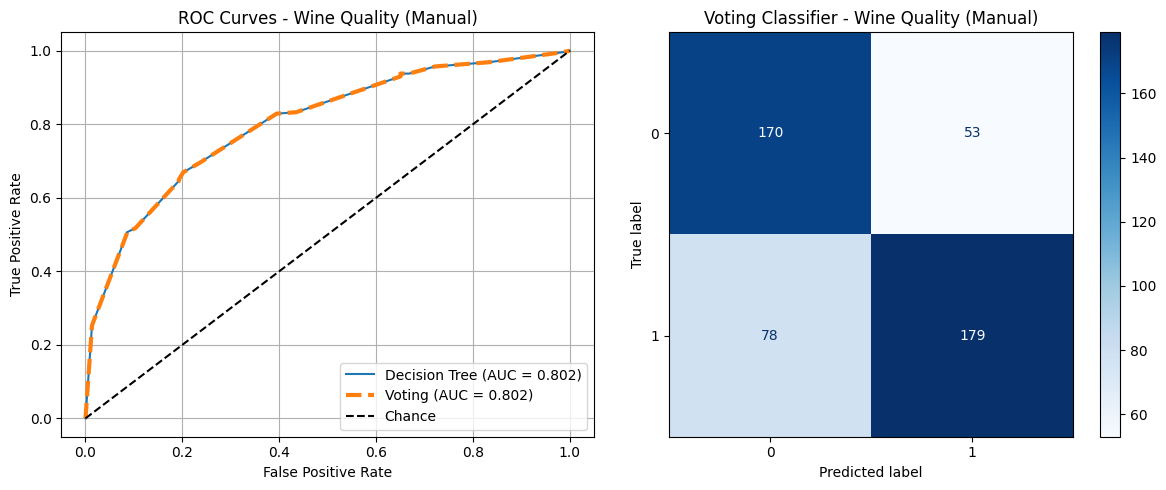


RUNNING BUILT-IN GRID SEARCH FOR WINE QUALITY

--- GridSearchCV for Decision Tree ---
Best params for Decision Tree: {'classifier__max_depth': 5, 'classifier__min_samples_split': 6, 'feature_selection__k': 5}
Best CV score: 0.7834

--- GridSearchCV for kNN ---
Best params for kNN: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance', 'feature_selection__k': 5}
Best CV score: 0.8603

--- GridSearchCV for Logistic Regression ---
Best params for Logistic Regression: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'feature_selection__k': 10}
Best CV score: 0.8048

EVALUATING BUILT-IN MODELS FOR WINE QUALITY

Decision Tree:
 Accuracy: 0.7292
 Precision: 0.7725
 Recall: 0.7004
 F1-Score: 0.7347
 ROC AUC: 0.8042

kNN:
 Accuracy: 0.7667
 Precision: 0.7757
 Recall: 0.7938
 F1-Score: 0.7846
 ROC AUC: 0.8675

Logistic Regression:
 Accuracy: 0.7417
 Precision: 0.7628
 Recall: 0.7510
 F1-Score: 0.7569
 ROC AUC: 0.8247

--- Built-in Voting Classifier ---

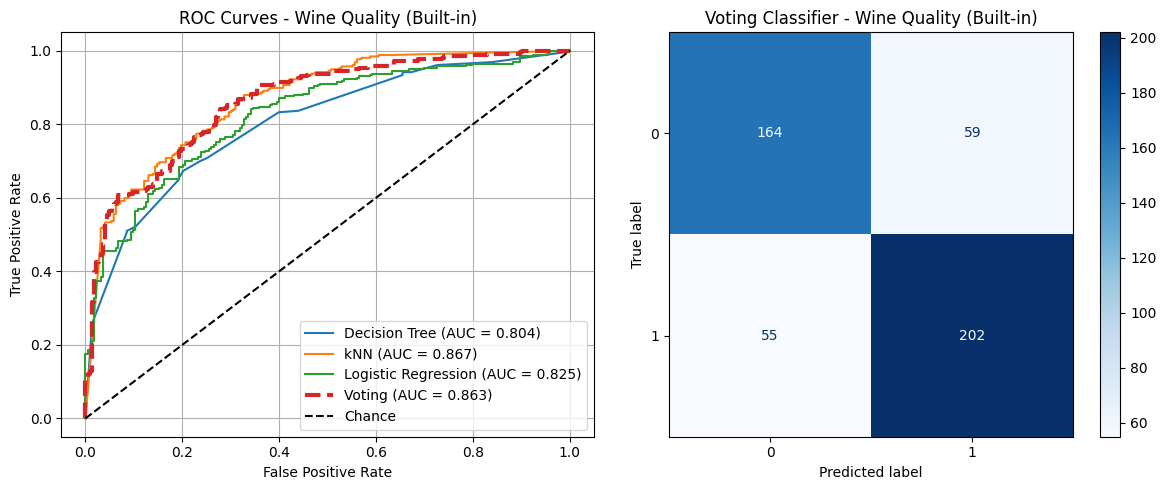


Completed processing for Wine Quality

################################################################################
PROCESSING DATASET: HR ATTRITION
################################################################################
IBM HR Attrition dataset loaded and preprocessed successfully.
Training set shape: (1029, 46)
Testing set shape: (441, 46)
------------------------------

RUNNING MANUAL GRID SEARCH FOR HR ATTRITION
--- Manual Grid Search for Decision Tree ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/l

------------------------------------------------------------------------------------------
Best parameters for Decision Tree: {'feature_selection__k': 5, 'classifier__max_depth': 3, 'classifier__min_samples_split': 4}
Best cross-validation AUC: 0.7156

EVALUATING MANUAL MODELS FOR HR ATTRITION

Decision Tree:
 Accuracy: 0.8231
 Precision: 0.3333
 Recall: 0.0986
 F1-Score: 0.1522
 ROC AUC: 0.7107

--- Manual Voting Classifier ---
Voting Classifier Performance:
 Accuracy: 0.8231, Precision: 0.3333
 Recall: 0.0986, F1: 0.1522, AUC: 0.7107


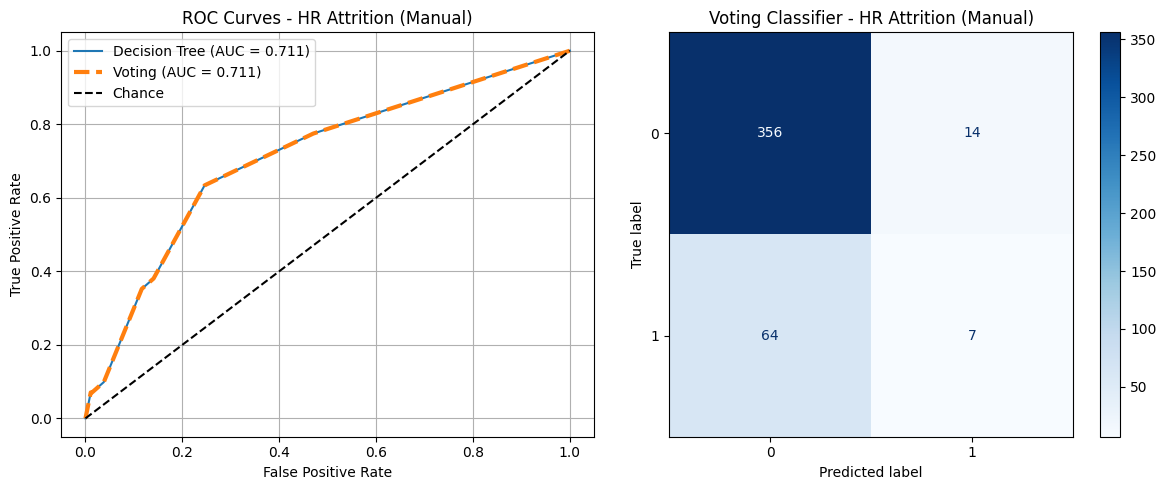


RUNNING BUILT-IN GRID SEARCH FOR HR ATTRITION

--- GridSearchCV for Decision Tree ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params for Decision Tree: {'classifier__max_depth': 3, 'classifier__min_samples_split': 2, 'feature_selection__k': 5}
Best CV score: 0.7156

--- GridSearchCV for kNN ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params for kNN: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance', 'feature_selection__k': 10}
Best CV score: 0.7073

--- GridSearchCV for Logistic Regression ---


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/l

Best params for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'feature_selection__k': 15}
Best CV score: 0.7776

EVALUATING BUILT-IN MODELS FOR HR ATTRITION

Decision Tree:
 Accuracy: 0.8231
 Precision: 0.3333
 Recall: 0.0986
 F1-Score: 0.1522
 ROC AUC: 0.7107

kNN:
 Accuracy: 0.8186
 Precision: 0.3953
 Recall: 0.2394
 F1-Score: 0.2982
 ROC AUC: 0.7130

Logistic Regression:
 Accuracy: 0.8571
 Precision: 0.6333
 Recall: 0.2676
 F1-Score: 0.3762
 ROC AUC: 0.7762

--- Built-in Voting Classifier ---
Voting Classifier Performance:
 Accuracy: 0.8345, Precision: 0.4667
 Recall: 0.1972, F1: 0.2772, AUC: 0.7676


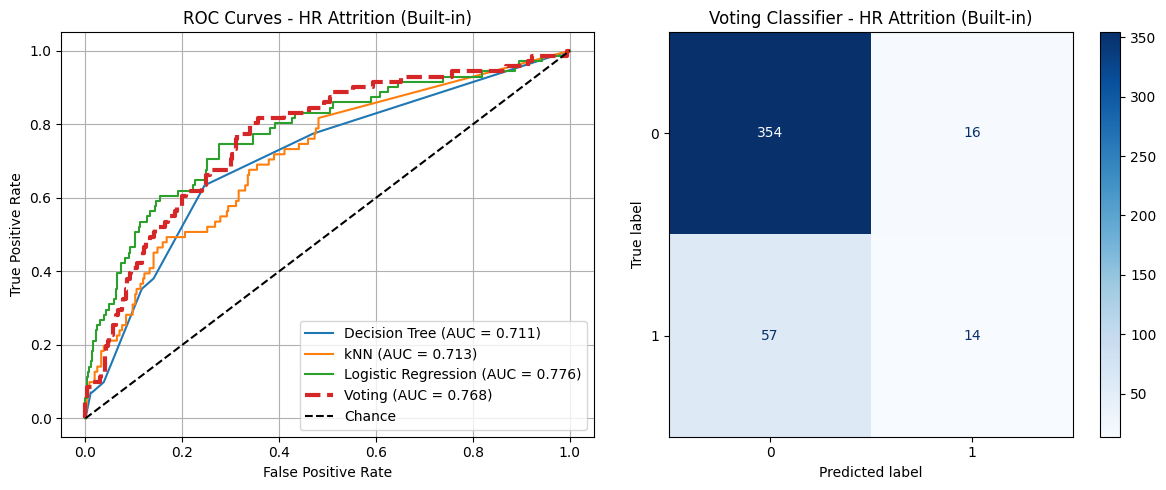


Completed processing for HR Attrition

ALL DATASETS PROCESSED!


In [24]:


datasets = [
    (load_wine_quality, "Wine Quality"),
    (load_hr_attrition, "HR Attrition"),
    (load_banknote, "Banknote Authentication"),
    (load_qsar_biodegradation, "QSAR Biodegradation")
]

for dataset_loader, dataset_name in datasets[:2]:  # Run for first two datasets for the assignment
    try:
        run_complete_pipeline(dataset_loader, dataset_name)
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")
        continue

print("\n" + "="*80)
print("ALL DATASETS PROCESSED!")
print("="*80)